# Intuition

We can have 2 kinds of predictions:

1. Given that the customer has not bought before, 
    1. Can we use their demographics to determine:
        1. How much (dollar amount) they will buy?
        2. How many items they will buy?
        3. What categories they will buy?
2. Given that the customer has made a purchase, 
    1. Can we see if their demographics, purchase history and purchase experience determine the likelihood of them returning?
        1. Compare the non-last transactions of repeat customers against transactions by single-time customers
    2. Can we compare past purchases to future ones? 
        1. E.g. to see if big spenders always spend big for all purchases. 
          Or those that buy from a certain category will continue to buy from that category. 
    3. Can we segment customers based on their purchase history? 
        1. Can also explore if particular segments have higher chance of returning customers. 
    
Can we segment customers based on what they purchase? E.g.:
* Those that purchase huge range of products
* Those that purchase only 1 item

# Import Data

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Markdown, display
from pandas_profiling import ProfileReport
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(14, 6)})

tqdm_notebook().pandas()

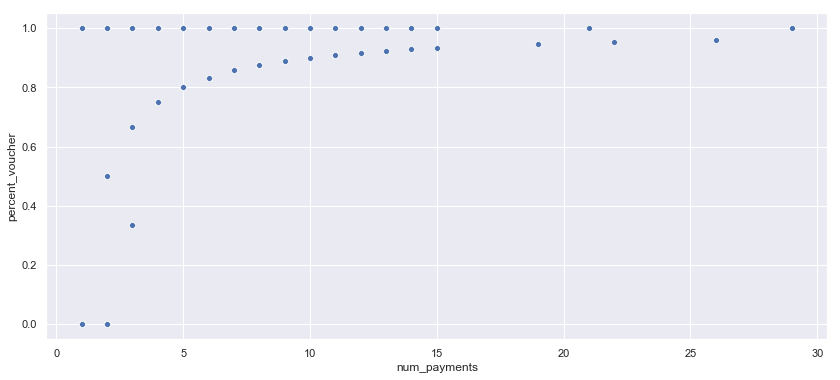

In [98]:
sns.scatterplot(order_payments.num_payments, order_payments.percent_voucher)

In [3]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv").set_index('product_id')
products.product_category_name.fillna('others', inplace=True)
order_items = order_items.join(products, on='product_id').drop(['order_item_id'], axis=1)

order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
order_payments = order_payments.groupby('order_id').agg({'payment_type': ['size', 'nunique', lambda x: (x == 'voucher').sum() / x.shape[0]], 'payment_installments': ['sum']})
order_payments.columns = ['num_payments', 'nunique_payments', 'percent_voucher', 'num_installments']

for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders[col] = pd.to_datetime(orders[col])
    
state_data = pd.read_csv("data/brazil_state_data.csv")
state_data.set_index('state', inplace=True)
state_data['gdp_per_capita'] = state_data['gdp'] / state_data['population']
state_data['population_density'] = state_data['population'] / state_data['size']
customers = customers.join(state_data, on='customer_state')

orders = orders.merge(customers, on='customer_id').drop('customer_id', axis=1).join(order_payments, on='order_id')

In [54]:
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])

* GDP Data: https://agenciadenoticias.ibge.gov.br/en/agencia-press-room/2185-news-agency/releases-en/10155-gdp-of-municipalities-agriculture-represents-more-than-half-of-economic-activity-in-1-135-municipalities
* Population Data: https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_gross_regional_product 
* Size Data: http://www.brazil-help.com/brazilian_states.htm

# Data Preparation

## Joining and preparing data columns

In [4]:
orders['time_to_approve'] = (orders.order_approved_at - orders.order_purchase_timestamp).dt.total_seconds()
orders['time_to_ship'] = (orders.order_delivered_carrier_date - orders.order_approved_at).dt.total_seconds()
orders['time_to_reach'] = (orders.order_delivered_customer_date - orders.order_delivered_carrier_date).dt.total_seconds()
orders['days_delivery_diff'] = (orders.order_estimated_delivery_date - orders.order_delivered_customer_date).dt.days
orders['month_purchase'] = orders.order_purchase_timestamp.dt.month

In [5]:
orders['customer_num_order'] = orders.groupby('customer_unique_id')['order_purchase_timestamp'].rank()

In [6]:
max_num_orders = pd.DataFrame(customers.customer_unique_id.value_counts())
max_num_orders.columns = ['max_num_orders']

In [7]:
order_details = order_items.groupby('order_id').agg({'price': ['size', 'sum', 'mean'], 'freight_value': ['sum', 'mean'], 'product_id': ['nunique'], 'seller_id': ['nunique']})
cols = ['_'.join(col) for col in order_details.columns]
cols[0] = 'num_items'
order_details.columns = cols

In [8]:
order_reviews = reviews.groupby('order_id').agg({'review_score': ['size', 'mean']})
order_reviews.columns = ['num_reviews', 'avg_review']

In [9]:
orders = orders.join(max_num_orders, on='customer_unique_id').join(order_details, on='order_id').join(order_reviews, on='order_id')

## Converting Categories

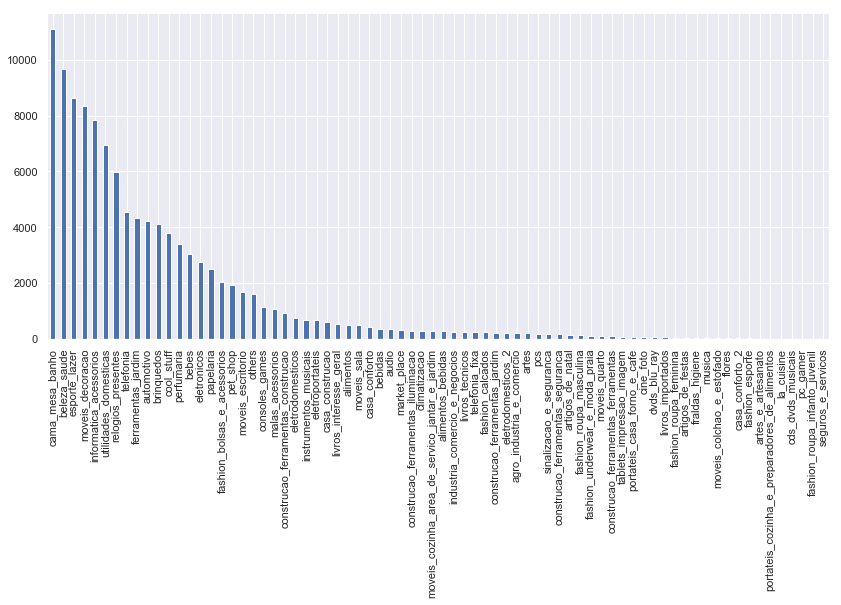

In [15]:
order_items.product_category_name.value_counts().plot(kind='bar')

In [10]:
first_n = 25
percent = order_items.product_category_name.value_counts()[:first_n].sum() / order_items.shape[0] * 100
display(Markdown("The first {} categories account for {:.2f}% of all orders. Let's convert the rest to \"others\".".format(first_n, percent)))

The first 25 categories account for 91.64% of all orders. Let's convert the rest to "others".

In [11]:
categories = pd.DataFrame(order_items.product_category_name.value_counts())
categories['product_category_name'] = categories.index
categories[first_n:]['product_category_name'] = 'others'

C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
if 'product_category' in order_items.columns:
    order_items.drop('product_category', axis=1, inplace=True)
categories.columns = ['product_category']
order_items = order_items.join(categories, on='product_category_name')

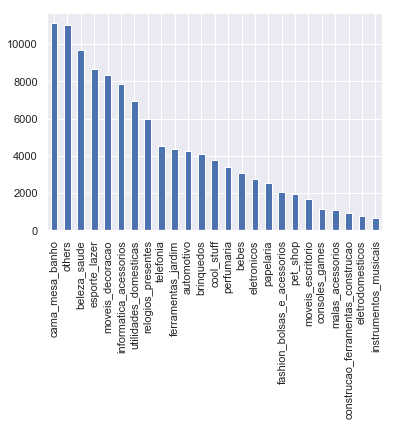

In [13]:
order_items.product_category.value_counts().plot(kind='bar')

# Some EDA

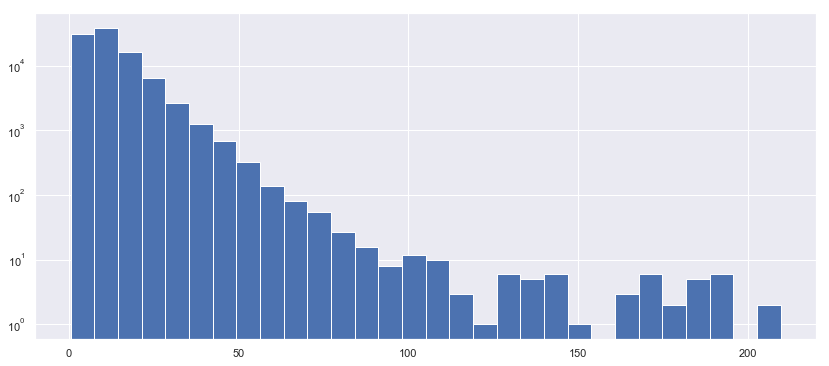

In [105]:
((orders.time_to_approve + orders.time_to_ship + orders.time_to_reach) / 86400).hist(bins = 30)
plt.yscale('log')

In [23]:
orders[['order_purchase_timestamp']].set_index('order_purchase_timestamp').resample('W').size().sort_values(ascending=False)

order_purchase_timestamp
2017-11-26    3008
2017-12-03    2098
2018-08-05    2058
2018-08-12    1988
2018-05-13    1987
2018-03-04    1903
2018-08-19    1875
2018-05-20    1837
2018-01-14    1785
2018-05-06    1770
2018-02-25    1756
2018-01-21    1750
2018-03-25    1716
2017-12-10    1692
2018-07-22    1678
2018-04-29    1676
2018-04-22    1672
2018-07-29    1646
2018-03-11    1643
2018-02-18    1640
2018-02-04    1598
2018-03-18    1595
2018-01-28    1591
2018-04-08    1590
2018-02-11    1584
2018-04-15    1554
2018-06-17    1514
2018-04-01    1471
2018-06-24    1457
2018-06-10    1438
              ... 
2017-01-29     354
2016-10-09     283
2017-01-22     197
2018-09-02     130
2017-01-15      80
2017-01-08      46
2016-10-16      39
2018-09-09       7
2018-09-16       4
2018-09-30       3
2016-09-18       2
2018-10-21       2
2018-10-07       2
2018-09-23       2
2016-09-04       1
2016-12-25       1
2016-09-11       1
2016-10-02       1
2016-10-23       1
2016-09-25       0
2018-1

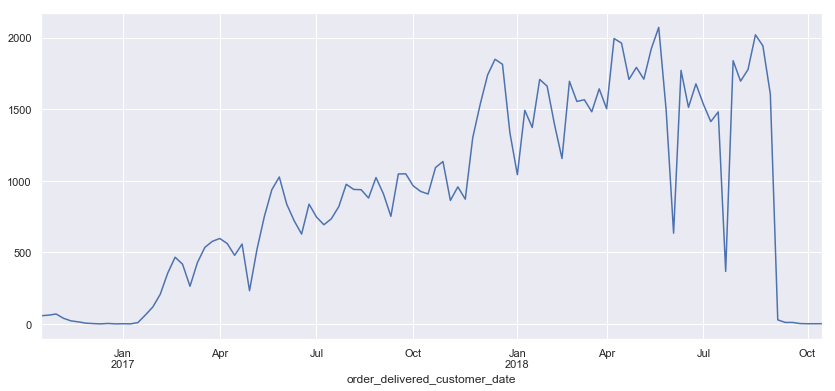

In [628]:
orders[['order_delivered_customer_date']].set_index('order_delivered_customer_date').resample('W').size().plot()

## Analysing Sellers vs Products

In [42]:
repeats = (customers.customer_unique_id.value_counts().value_counts(normalize=True).sort_index() * 100)
repeats[3:].sum()

0.05099067599067599

In [377]:
tmp = order_items.join(orders.set_index('order_id'), on='order_id')

In [389]:
tmp[['seller_id', 'product_id']].drop_duplicates().groupby('product_id').size().sort_values(ascending=False).head()

product_id
d285360f29ac7fd97640bf0baef03de0    8
69455f41626a745aea9ee9164cb9eafd    8
4298b7e67dc399c200662b569563a2b2    7
36f60d45225e60c7da4558b070ce4b60    7
656e0eca68dcecf6a31b8ececfabe3e8    7
dtype: int64

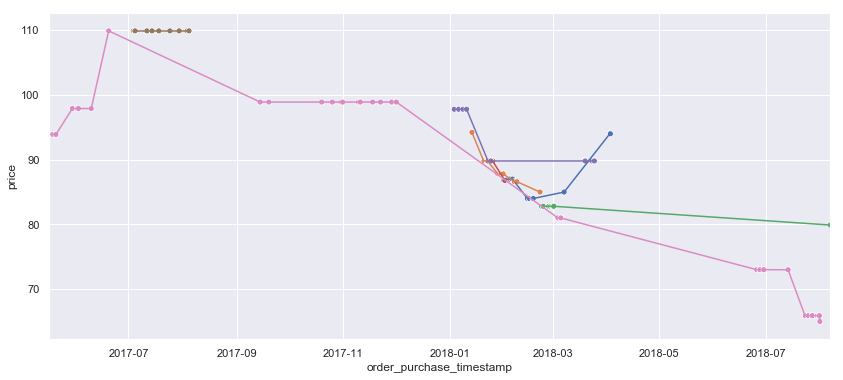

In [396]:
t = tmp[['order_purchase_timestamp', 'seller_id', 'product_id', 'price']].drop_duplicates()
t = t[t.product_id == '656e0eca68dcecf6a31b8ececfabe3e8'].sort_values(['seller_id', 'order_purchase_timestamp'])
sns.lineplot(t.order_purchase_timestamp, t.price, hue=t.seller_id)
sns.scatterplot(t.order_purchase_timestamp, t.price, hue=t.seller_id)
plt.xlim(t.order_purchase_timestamp.min(), t.order_purchase_timestamp.max())
plt.legend().remove()

# Analysis

In [13]:
from sklearn.metrics import mean_squared_error

## Analysing All Customers

### Using Demographics to Predict Purchase Volume

In [16]:
orders.columns

Index(['order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'gdp', 'size', 'population', 'gdp_per_capita',
       'population_density', 'num_payments', 'nunique_payments',
       'percent_voucher', 'num_installments', 'time_to_approve',
       'time_to_ship', 'time_to_reach', 'days_delivery_diff', 'month_purchase',
       'customer_num_order', 'max_num_orders', 'num_items', 'price_sum',
       'price_mean', 'freight_value_sum', 'freight_value_mean',
       'product_id_nunique', 'seller_id_nunique', 'num_reviews', 'avg_review'],
      dtype='object')

In [53]:
customers.customer_zip_code_prefix.nunique()

14994

In [45]:
orders[['price_sum', 'num_items', 'customer_state', 'gdp', 'size', 'population', 'customer_city', 'customer_zip_code_prefix']].head()

,price_sum,num_items,customer_state,gdp,size,population,customer_city,customer_zip_code_prefix
0,29.99,1.0,SP,628064882,248209,44035304,sao paulo,3149
1,118.70,1.0,BA,56624041,564692,15126371,barreiras,47813
2,159.90,1.0,GO,46094735,340086,6523222,vianopolis,75265
3,45.00,1.0,RN,19076030,52796,3408510,sao goncalo do amarante,59296
4,19.90,1.0,SP,628064882,248209,44035304,santo andre,9195


In [28]:
orders[['population_density', 'size', 'population']].corr().abs()

,population_density,size,population
population_density,1.000000,0.620802,0.195046
size,0.620802,1.000000,0.003085
population,0.195046,0.003085,1.000000


In [35]:
orders[['num_items', 'seller_id_nunique', 'product_id_nunique']].corr()

,num_items,seller_id_nunique,product_id_nunique
num_items,1.000000,0.282200,0.470977
seller_id_nunique,0.282200,1.000000,0.592784
product_id_nunique,0.470977,0.592784,1.000000


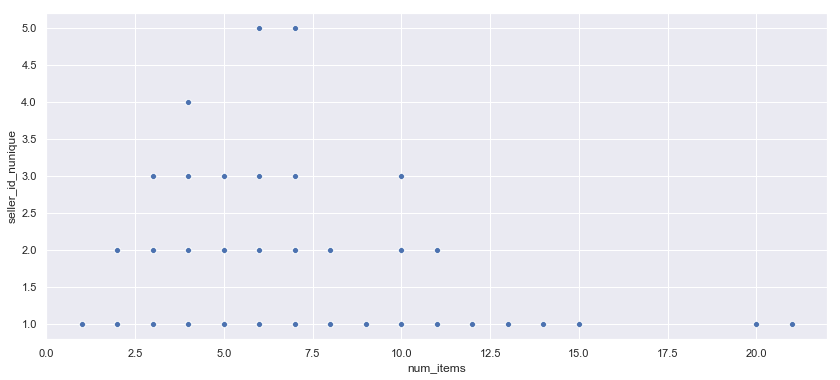

In [34]:
sns.scatterplot(orders.num_items, orders.seller_id_nunique)

In [37]:
orders

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,...,max_num_orders,num_items,price_sum,price_mean,freight_value_sum,freight_value_mean,product_id_nunique,seller_id_nunique,num_reviews,avg_review
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,...,2,1.0,29.99,29.990,8.72,8.72,1.0,1.0,1,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,...,1,1.0,118.70,118.700,22.76,22.76,1.0,1.0,1,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,...,1,1.0,159.90,159.900,19.22,19.22,1.0,1.0,1,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,...,1,1.0,45.00,45.000,27.20,27.20,1.0,1.0,1,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,...,1,1.0,19.90,19.900,8.72,8.72,1.0,1.0,1,5.0
5,a4591c265e18cb1dcee52889e2d8acc3,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,...,1,1.0,147.90,147.900,27.36,27.36,1.0,1.0,1,4.0
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,...,1,1.0,49.90,49.900,16.05,16.05,1.0,1.0,1,2.0
7,6514b8ad8028c9f2cc2374ded245783f,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,...,1,1.0,59.99,59.990,15.17,15.17,1.0,1.0,1,5.0
8,76c6e866289321a7c93b82b54852dc33,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,...,1,1.0,19.90,19.900,16.05,16.05,1.0,1.0,1,1.0
9,e69bfb5eb88e0ed6a785585b27e16dbf,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,299905e3934e9e181bfb2e164dd4b4f8,18075,sorocaba,...,1,1.0,149.99,149.990,19.77,19.77,1.0,1.0,1,5.0


In [40]:
order_items

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,ferramentas_jardim
5,00048cc3ae777c65dbb7d2a0634bc1ea,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69,utilidades_domesticas,36.0,558.0,1.0,450.0,24.0,8.0,15.0,utilidades_domesticas
6,00054e8431b9d7675808bcb819fb4a32,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85,telefonia,52.0,815.0,1.0,200.0,27.0,5.0,20.0,telefonia
7,000576fe39319847cbb9d288c5617fa6,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75,ferramentas_jardim,39.0,1310.0,3.0,13805.0,35.0,75.0,45.0,ferramentas_jardim
8,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65,beleza_saude,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,beleza_saude
9,0005f50442cb953dcd1d21e1fb923495,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40,livros_tecnicos,52.0,1192.0,1.0,850.0,29.0,3.0,21.0,others


In [39]:
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [105]:
for y_col in ['price_sum', 'avg_review', 'num_items', 'seller_id_nunique', 'product_id_nunique', 'num_reviews']:
    display(Markdown("# " + y_col))
    subset = orders[['population', 'gdp_per_capita', 'size', y_col]].dropna() # excluded GDP because high correlation
    subset = np.log1p(subset)
    X = sm.add_constant(subset.drop(y_col, axis=1))
    y = subset[y_col]

    while True:
        model = sm.OLS(y, X).fit()
        pvals = pd.DataFrame(model.pvalues).drop('const')
        max_pval = pvals.max()[0]
        if max_pval > 0.05:
            to_drop = pvals[pvals[0] == pvals[0].max()].index[0]
            display(Markdown("Dropping `" + to_drop + "` (p-val: `{:.4f}`)".format(max_pval)))
            X.drop(to_drop, inplace=True, axis=1)
        else:
            # no columns with pval > 0.05
            break
    display(model.summary())
#     model, best_score, pred_y = stepwise_regression('ols', subset.drop(y, axis=1), subset[y])
#     display(model.summary())

# price_sum

Dropping `size` (p-val: `0.1659`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_sum   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     260.1
Date:                Wed, 24 Apr 2019   Prob (F-statistic):          2.09e-113
Time:                        01:38:57   Log-Likelihood:            -1.3138e+05
No. Observations:               98666   AIC:                         2.628e+05
Df Residuals:                   98663   BIC:                         2.628e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6830      0.057     98.931      0.000       5.570       5.796
population        -0.0690      0.004    -19.169      0.000      -0.076      -0.062
gdp_per_capita    -0.0268      0.005     -5.100      0.000      -0.037      -0.017
==============================================================================
Omnibus:                     1609.742   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1780.515
Skew:                           0.283   Prob(JB):                         0.00
Kurtosis:                       3.337   Cond. No.                         335.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# avg_review

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_review   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     99.82
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           1.62e-64
Time:                        01:38:57   Log-Likelihood:                -39276.
No. Observations:               99441   AIC:                         7.856e+04
Df Residuals:                   99437   BIC:                         7.860e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1953      0.023     51.319      0.000       1.150       1.241
population         0.0056      0.002      2.857      0.004       0.002       0.010
gdp_per_capita     0.0171      0.003      5.355      0.000       0.011       0.023
size               0.0197      0.002     10.111      0.000       0.016       0.024
==============================================================================
Omnibus:                    26372.594   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53245.929
Skew:                          -1.658   Prob(JB):                         0.00
Kurtosis:                       4.360   Cond. No.                         428.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# num_items

Dropping `population` (p-val: `0.4000`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_items   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.094
Date:                Wed, 24 Apr 2019   Prob (F-statistic):            0.00613
Time:                        01:38:57   Log-Likelihood:                 36477.
No. Observations:               98666   AIC:                        -7.295e+04
Df Residuals:                   98663   BIC:                        -7.292e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7157      0.010     75.021      0.000       0.697       0.734
gdp_per_capita     0.0032      0.001      2.975      0.003       0.001       0.005
size               0.0017      0.001      2.592      0.010       0.000       0.003
==============================================================================
Omnibus:                    80958.272   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1804788.576
Skew:                           3.975   Prob(JB):                         0.00
Kurtosis:                      22.386   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# seller_id_nunique

Dropping `population` (p-val: `0.6947`)

Dropping `gdp_per_capita` (p-val: `0.0761`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seller_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.539
Date:                Wed, 24 Apr 2019   Prob (F-statistic):             0.0331
Time:                        01:38:57   Log-Likelihood:             1.5938e+05
No. Observations:               98666   AIC:                        -3.188e+05
Df Residuals:                   98664   BIC:                        -3.187e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6945      0.002    364.371      0.000       0.691       0.698
size           0.0003      0.000      2.131      0.033    2.67e-05       0.001
==============================================================================
Omnibus:                   143549.812   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33363018.497
Skew:                           9.143   Prob(JB):                         0.00
Kurtosis:                      91.210   Cond. No.                         153.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# product_id_nunique

Dropping `population` (p-val: `0.7495`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     product_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.241
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           0.000717
Time:                        01:38:57   Log-Likelihood:             1.0542e+05
No. Observations:               98666   AIC:                        -2.108e+05
Df Residuals:                   98663   BIC:                        -2.108e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6916      0.005    145.812      0.000       0.682       0.701
gdp_per_capita     0.0019      0.001      3.616      0.000       0.001       0.003
size               0.0010      0.000      2.968      0.003       0.000       0.002
==============================================================================
Omnibus:                   113491.986   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8933458.253
Skew:                           6.245   Prob(JB):                         0.00
Kurtosis:                      47.911   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# num_reviews

Dropping `size` (p-val: `0.2247`)

Dropping `population` (p-val: `0.2204`)

Dropping `gdp_per_capita` (p-val: `0.2217`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_reviews   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Wed, 24 Apr 2019   Prob (F-statistic):                nan
Time:                        01:38:57   Log-Likelihood:             2.0623e+05
No. Observations:               99441   AIC:                        -4.125e+05
Df Residuals:                   99440   BIC:                        -4.124e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6954   9.65e-05   7209.989      0.000       0.695       0.696
==============================================================================
Omnibus:                   177660.443   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        135439963.248
Skew:                          13.378   Prob(JB):                         0.00
Kurtosis:                     181.808   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
model.tvalues

const                 795.432947
population              1.761143
gdp_per_capita          0.180678
size                    0.836748
population_density     -0.213841
dtype: float64

In [122]:
for y_col in ['price_sum', 'num_items', 'seller_id_nunique']:
    display(Markdown("# " + y_col))
    sub = orders[[y_col, 'gdp_per_capita', 'size']].dropna()
    X2 = sm.add_constant(sub.drop(y_col, axis=1))
    X2['gdp_per_capita'] = np.log1p(X2['gdp_per_capita'])
    X2['size'] = np.log1p(X2['size'])
    est = sm.OLS(np.log1p(sub[y_col]), X2)
    est2 = est.fit()
    display(est2.summary())

# price_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_sum   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.59
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           2.52e-05
Time:                        14:32:09   Log-Likelihood:            -6.6787e+05
No. Observations:               98666   AIC:                         1.336e+06
Df Residuals:                   98663   BIC:                         1.336e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            139.7726      1.701     82.161      0.000     136.438     143.107
gdp_per_capita    -0.2628      0.074     -3.541      0.000      -0.408      -0.117
size            4.259e-06   3.56e-06      1.195      0.232   -2.73e-06    1.12e-05
==============================================================================
Omnibus:                   155664.544   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        293055456.906
Skew:                           9.731   Prob(JB):                         0.00
Kurtosis:                     269.281   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# num_items

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_items   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1182
Date:                Tue, 23 Apr 2019   Prob (F-statistic):              0.888
Time:                        14:32:09   Log-Likelihood:                -78921.
No. Observations:               98666   AIC:                         1.578e+05
Df Residuals:                   98663   BIC:                         1.579e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1408      0.004    262.299      0.000       1.132       1.149
gdp_per_capita  8.298e-05      0.000      0.437      0.662      -0.000       0.000
size           -9.673e-11   9.11e-09     -0.011      0.992    -1.8e-08    1.78e-08
==============================================================================
Omnibus:                   132810.611   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         55156239.033
Skew:                           7.527   Prob(JB):                         0.00
Kurtosis:                     117.847   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# seller_id_nunique

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seller_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7834
Date:                Tue, 23 Apr 2019   Prob (F-statistic):              0.457
Time:                        14:32:09   Log-Likelihood:                 67327.
No. Observations:               98666   AIC:                        -1.346e+05
Df Residuals:                   98663   BIC:                        -1.346e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0128      0.001   1025.314      0.000       1.011       1.015
gdp_per_capita   1.21e-05   4.31e-05      0.281      0.779   -7.23e-05    9.65e-05
size            2.537e-09   2.07e-09      1.226      0.220   -1.52e-09    6.59e-09
==============================================================================
Omnibus:                   151974.012   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         61878181.375
Skew:                           9.970   Prob(JB):                         0.00
Kurtosis:                     124.053   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Using Demographics to Predict Purchase Items

In [109]:
subset = orders[['order_id', 'gdp_per_capita', 'gdp', 'population', 'size', 'population_density']].join(order_items.set_index('order_id')[['product_category']], on='order_id', how='right').drop('order_id', axis=1)

In [18]:
subset.groupby('product_category')['gdp_per_capita'].mean()

product_category
automotivo                           11.933927
bebes                                11.937448
beleza_saude                         12.205829
brinquedos                           12.362574
cama_mesa_banho                      12.585952
consoles_games                       12.341583
construcao_ferramentas_construcao    11.830202
cool_stuff                           11.584447
eletrodomesticos                     11.952558
eletronicos                          11.751040
esporte_lazer                        12.274424
fashion_bolsas_e_acessorios          11.715178
ferramentas_jardim                   11.256768
informatica_acessorios               11.845284
instrumentos_musicais                11.199534
malas_acessorios                     11.812197
moveis_decoracao                     11.903564
moveis_escritorio                    11.743079
others                               12.222114
papelaria                            11.994282
perfumaria                           12.467

# gdp_per_capita

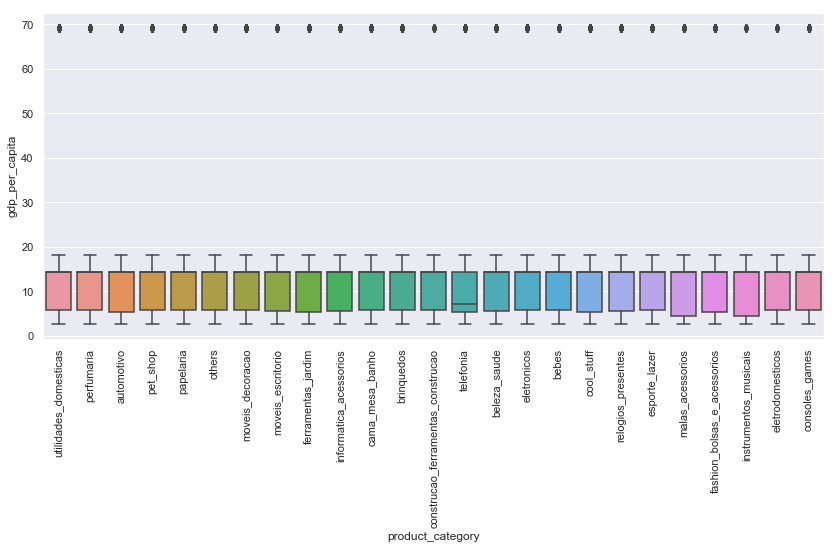

# gdp

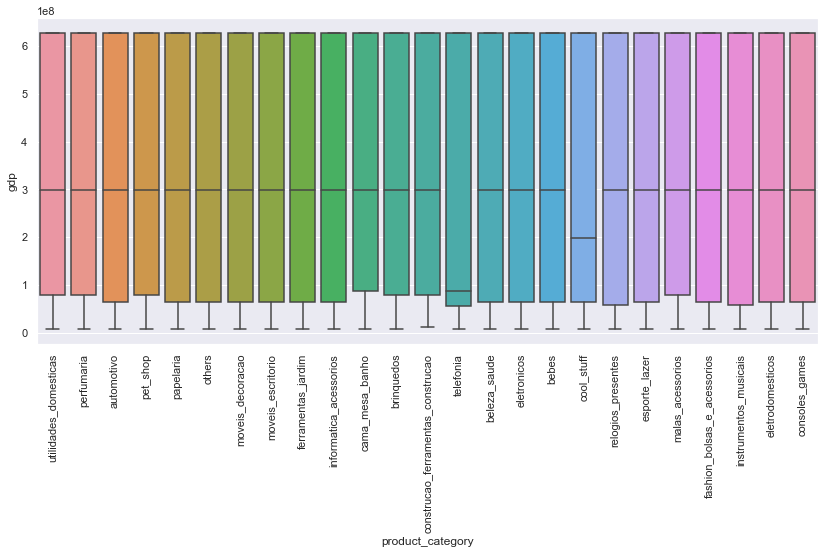

# population

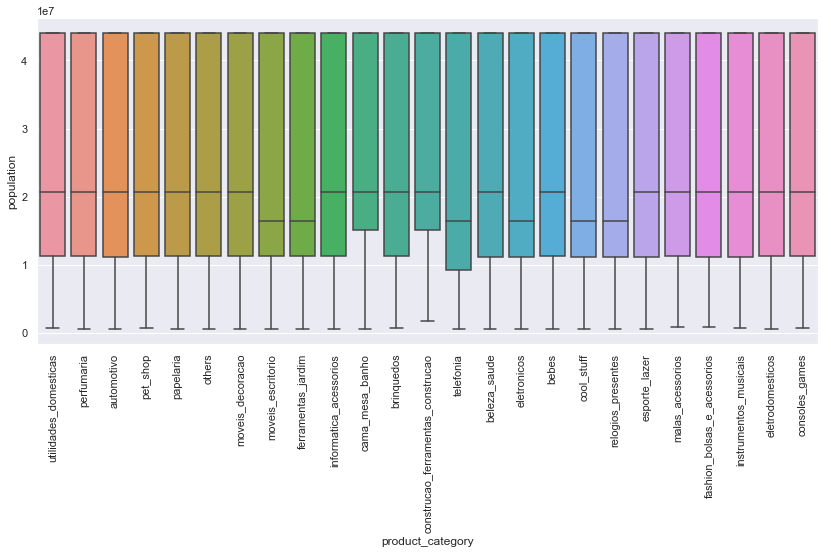

# size

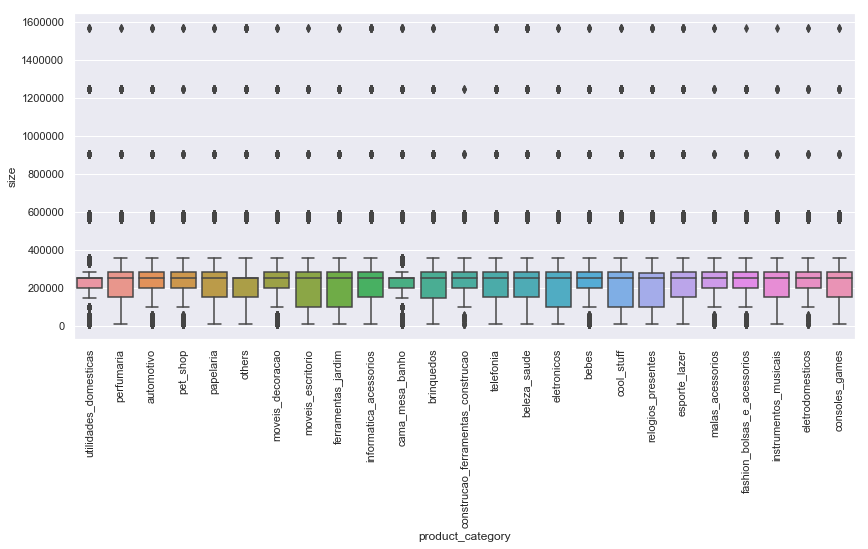

# population_density

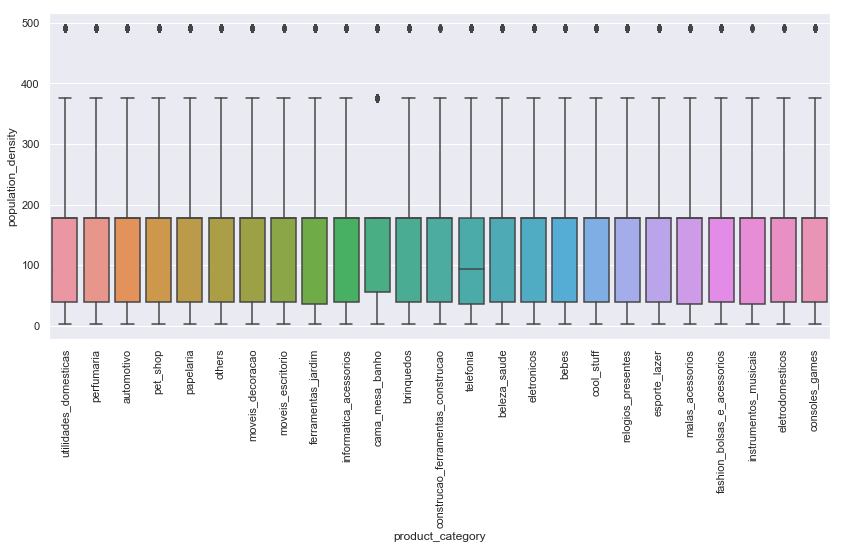

In [111]:
for col in ['gdp_per_capita', 'gdp', 'population', 'size', 'population_density']:
    display(Markdown("# " + col))
    sns.boxplot(subset.product_category, subset[col], showfliers=True)
    plt.xticks(rotation=90)
#     plt.yticks(np.exp(plt.yticks()[0]-1))
#     plt.yscale('log')
    plt.show()

## Analysing Return Customers

### See if demographics, purchase history and purchase experience determine the likelihood of customers returning

In [113]:
orders_filtered = orders[(orders.max_num_orders == 1) | ((orders.max_num_orders > 1) & (orders.max_num_orders > orders.customer_num_order))]

In [221]:
orders_filtered['population_density'] = orders_filtered['population'] / orders_filtered['size']

In [167]:
for month in range(1, 13):
    subset = orders_filtered[orders_filtered.month_purchase == month]
    print("Month{: 3}: {:.2f}% repeat customers".format(month, (subset.max_num_orders > 1).sum() / subset.shape[0] * 100))

Month  1: 4.26% repeat customers
Month  2: 4.65% repeat customers
Month  3: 3.70% repeat customers
Month  4: 3.15% repeat customers
Month  5: 3.50% repeat customers
Month  6: 3.19% repeat customers
Month  7: 3.59% repeat customers
Month  8: 2.97% repeat customers
Month  9: 5.50% repeat customers
Month 10: 4.46% repeat customers
Month 11: 3.99% repeat customers
Month 12: 3.44% repeat customers


C:\Users\leeye\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, '% of customers who return later on')

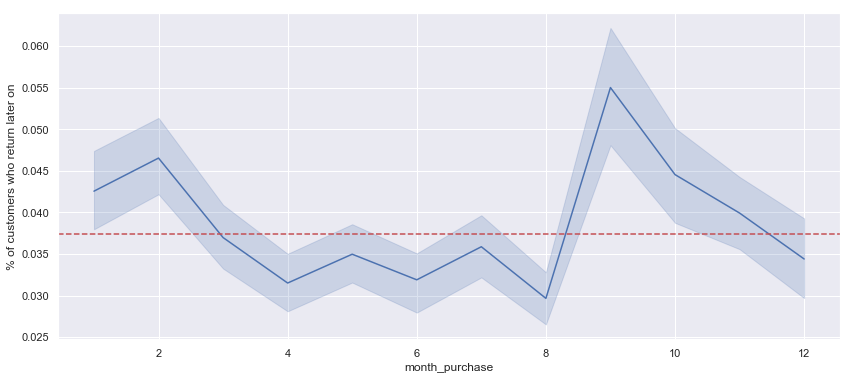

In [168]:
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1)
plt.axhline(y = (orders_filtered.max_num_orders > 1).sum() / orders_filtered.shape[0], color = 'r', linestyle='--')
plt.ylabel("% of customers who return later on")

From the above plot, we can see that there is a discernible difference in % of recurring customers for each month. 

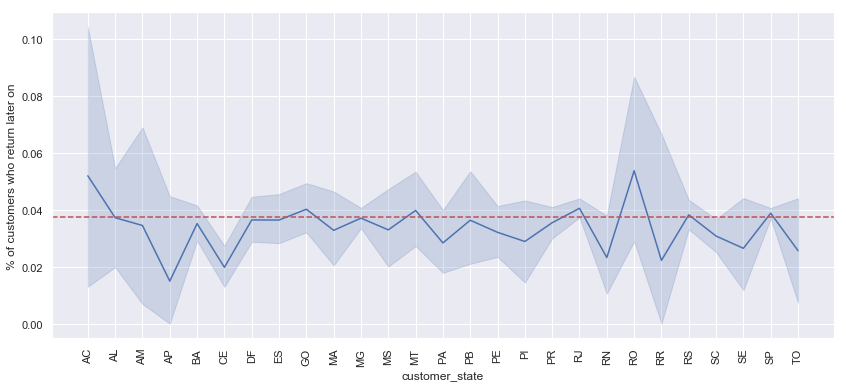

In [169]:
sns.lineplot(orders_filtered.customer_state, orders_filtered.max_num_orders > 1)
plt.axhline(y = (orders_filtered.max_num_orders > 1).sum() / orders_filtered.shape[0], color = 'r', linestyle='--')
plt.ylabel("% of customers who return later on")
_ = plt.xticks(rotation=90)

From the above plot, we can also see that there is a discernible difference in % of recurring customers for each state. 

In [214]:
tmp = pd.DataFrame(orders_filtered.groupby(['customer_state', 'month_purchase'])['max_num_orders'].agg(lambda x: (x > 1).sum() / x.shape[0])).reset_index().pivot(index='customer_state', columns='month_purchase')
tmp.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

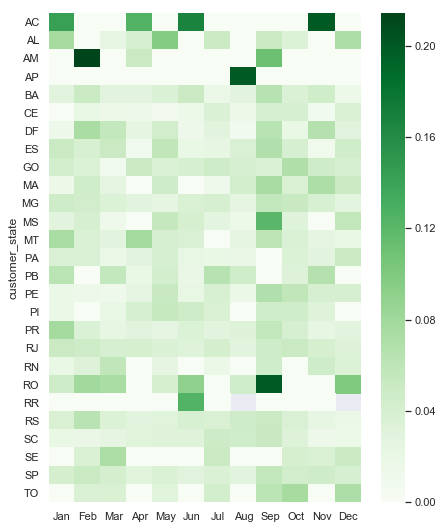

In [215]:
plt.figure(figsize=(7, 9))
sns.heatmap(tmp, cmap='Greens')
_ = plt.yticks(rotation=0)

In [222]:
numeric_columns = [x for x in orders_filtered.drop(['customer_zip_code_prefix', 'customer_num_order'], axis=1).columns if (orders_filtered[x].dtype == np.float64 or orders_filtered[x].dtype == np.int64)]

In [223]:
numeric_columns

['gdp',
 'size',
 'population',
 'gdp_per_capita',
 'population_density',
 'num_payments',
 'nunique_payments',
 'percent_voucher',
 'num_installments',
 'time_to_approve',
 'time_to_ship',
 'time_to_reach',
 'days_delivery_diff',
 'month_purchase',
 'max_num_orders',
 'num_items',
 'price_sum',
 'price_mean',
 'freight_value_sum',
 'freight_value_mean',
 'product_id_nunique',
 'seller_id_nunique',
 'num_reviews',
 'avg_review']

In [233]:
# remove population (high correlation), size, gdp_per_capita, seller_id_nunique, avg_review (high p-value)

# subset = orders_filtered[['max_num_orders', 'gdp', 'time_to_approve', 
#         'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
#         'num_items', 'price_sum', 'freight_value_mean', 'month_purchase', 
#         'num_reviews']]

subset = orders_filtered[numeric_columns]

for col in subset.columns:
    np.ma.fix_invalid(subset[col], copy = False, fill_value=np.ma.masked_invalid(subset[col]).mean())
#     subset[col] = np.log1p(subset[col])
        
# for col in ['freight_value_sum', 'freight_value_mean', 'gdp_per_capita', 'num_items', 'price_sum', 'size', 'time_to_approve']:
#     if col in subset.columns:
#         subset[col] = np.log1p(subset[col])

subset['y'] = subset.max_num_orders > 1
subset.drop('max_num_orders', inplace=True, axis=1)

In [248]:
def stepwise_regression(model_type, df, y):
    
    def process(cols):
        X = sm.add_constant(df[cols])
        if model_type == "ols":
            model = sm.OLS(y, X).fit(disp = 0)
        else:
            model = sm.Logit(y, X).fit(disp = 0)
        pred_y = round(model.predict(X))
        return (model, pred_y)
    
    selected_columns = []
    available_columns = df.columns
    best_score = 0
    best_aic = np.inf
    best_pred_y = pd.Series()
    while len(selected_columns) < len(available_columns):
        col_to_add = None
        for col in available_columns:
            if col in selected_columns:
                continue
            # Build a model with each col
            X = sm.add_constant(df[selected_columns + [col]])
            try:
                model, pred_y = process(selected_columns + [col])
            except:
                continue
            if model_type == "ols":
                score = mean_squared_error(y, pred_y)
            else:
                score = recall_score(y, pred_y)
            if model.aic < best_aic: # score > best_score or (score == best_score and model.aic < best_aic):
                best_score = score
                best_aic = model.aic
                col_to_add = col
                best_pred_y = pred_y
            
        if col_to_add is None:
            # Couldn't find anything better
            X = sm.add_constant(df[selected_columns])
            model, pred_y = process(selected_columns)
            return (model, best_score, pred_y)
        else:
            selected_columns.append(col_to_add)
    X = sm.add_constant(df[selected_columns])
    model, pred_y = process(selected_columns)
    return (model, best_score, pred_y)

In [249]:
model, best_score, pred_y = stepwise_regression('', subset.drop(['y', 'month_purchase'], axis=1), subset.y)
print("Recall: {:.3f}%".format(best_score * 100))

Recall: 8.910%


In [254]:
precision_score(subset.y, pred_y)

0.7931034482758621

In [255]:
recall_score(subset.y, pred_y)

0.08909795240730492

In [256]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                96713
Model:                          Logit   Df Residuals:                    96699
Method:                           MLE   Df Model:                           13
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.06602
Time:                        02:48:40   Log-Likelihood:                -14406.
converged:                       True   LL-Null:                       -15425.
                                        LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.7559      0.180    -48.636      0.000      -9.109      -8.403
num_reviews            4.6320      0.125     37.104      0.000       4.387       4.877
num_installments       0.0676      0.006     10.522      0.000       0.055       0.080
price_mean            -0.0010      0.000     -6.131      0.000      -0.001      -0.001
num_items              0.1149      0.028      4.142      0.000       0.061       0.169
days_delivery_diff     0.0145      0.002      6.428      0.000       0.010       0.019
percent_voucher        0.5685      0.119      4.758      0.000       0.334       0.803
freight_value_mean    -0.0054      0.002     -3.297      0.001      -0.009      -0.002
time_to_ship        2.597e-07   5.64e-08      4.607      0.000    1.49e-07     3.7e-07
product_id_nunique     0.1987      0.064      3.095      0.002       0.073       0.324
gdp                 2.766e-10   7.81e-11      3.542      0.000    1.24e-10     4.3e-10
time_to_reach       1.087e-07   3.58e-08      3.036      0.002    3.85e-08    1.79e-07
avg_review             0.0303      0.014      2.156      0.031       0.003       0.058
num_payments          -0.0988      0.051     -1.920      0.055      -0.200       0.002
======================================================================================
"""

In [600]:
# ProfileReport(subset.drop('y', axis=1))

In [213]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [257]:
true_y = pd.Series()
pred_y = pd.Series()
month_recalls = []

for month in tqdm_notebook(range(1, 13)):
    X = subset[subset.month_purchase == month].drop(['y', 'month_purchase'], axis=1)
    y = subset[subset.month_purchase == month].y
    
#     pred = round(model.predict(sm.add_constant(X[['num_reviews']])))
#     true_y = true_y.append(y)
#     pred_y = pred_y.append(pred)
#     month_recalls.append(recall_score(y, pred) * 100)
    
    model, best_score, pred_y_found = stepwise_regression('', X, y)
    true_y = true_y.append(y)
    pred_y = pred_y.append(pred_y_found)
    display(Markdown("# Month " + str(month)))
    display(model.summary())
    display(Markdown("Recall: {:.3f}%".format(best_score * 100)))
    month_recalls.append(best_score * 100)

print("Precision: {: 7.3f}%".format(precision_score(true_y, pred_y) * 100))
print("Recall:    {: 7.3f}%".format(recall_score(true_y, pred_y) * 100))

# Month 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7847
Model:                          Logit   Df Residuals:                     7840
Method:                           MLE   Df Model:                            6
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.07161
Time:                        02:48:51   Log-Likelihood:                -1282.2
converged:                       True   LL-Null:                       -1381.1
                                        LLR p-value:                 5.539e-40
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.9645      0.483    -16.490      0.000      -8.911      -7.018
num_reviews            4.5759      0.435     10.519      0.000       3.723       5.429
days_delivery_diff     0.0265      0.006      4.665      0.000       0.015       0.038
percent_voucher        1.0578      0.333      3.177      0.001       0.405       1.710
price_mean            -0.0016      0.001     -2.873      0.004      -0.003      -0.001
num_installments       0.0784      0.022      3.593      0.000       0.036       0.121
num_payments          -0.2762      0.198     -1.397      0.162      -0.664       0.111
======================================================================================
"""

Recall: 8.683%

# Month 2

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8271
Model:                          Logit   Df Residuals:                     8262
Method:                           MLE   Df Model:                            8
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                  0.1054
Time:                        02:48:53   Log-Likelihood:                -1392.7
converged:                       True   LL-Null:                       -1556.8
                                        LLR p-value:                 3.967e-66
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.4795      0.379    -22.360      0.000      -9.223      -7.736
num_reviews            4.7382      0.327     14.479      0.000       4.097       5.380
gdp_per_capita         0.0131      0.005      2.814      0.005       0.004       0.022
price_mean            -0.0034      0.001     -3.840      0.000      -0.005      -0.002
num_installments       0.0698      0.022      3.175      0.001       0.027       0.113
price_sum              0.0016      0.001      2.448      0.014       0.000       0.003
time_to_ship        4.348e-07   1.62e-07      2.684      0.007    1.17e-07    7.52e-07
days_delivery_diff     0.0107      0.005      2.141      0.032       0.001       0.021
gdp                 4.302e-10   2.19e-10      1.968      0.049    1.65e-12    8.59e-10
======================================================================================
"""

Recall: 14.286%

# Month 3

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9654
Model:                          Logit   Df Residuals:                     9646
Method:                           MLE   Df Model:                            7
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.06982
Time:                        02:48:55   Log-Likelihood:                -1420.8
converged:                       True   LL-Null:                       -1527.5
                                        LLR p-value:                 1.756e-42
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -9.5928      0.595    -16.126      0.000     -10.759      -8.427
num_reviews           4.5555      0.389     11.711      0.000       3.793       5.318
num_installments      0.0973      0.020      4.889      0.000       0.058       0.136
price_mean           -0.0016      0.001     -3.156      0.002      -0.003      -0.001
gdp                4.305e-10   2.22e-10      1.937      0.053   -5.21e-12    8.66e-10
avg_review            0.1077      0.041      2.656      0.008       0.028       0.187
seller_id_nunique     0.8610      0.367      2.343      0.019       0.141       1.581
gdp_per_capita        0.0098      0.005      1.878      0.060      -0.000       0.020
=====================================================================================
"""

Recall: 8.683%

# Month 4

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9109
Model:                          Logit   Df Residuals:                     9102
Method:                           MLE   Df Model:                            6
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.03163
Time:                        02:48:56   Log-Likelihood:                -1234.4
converged:                       True   LL-Null:                       -1274.7
                                        LLR p-value:                 2.636e-15
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.5791      0.685    -12.526      0.000      -9.921      -7.237
num_reviews            4.8139      0.660      7.290      0.000       3.520       6.108
num_installments       0.0596      0.021      2.809      0.005       0.018       0.101
time_to_ship        4.679e-07   1.95e-07      2.406      0.016    8.67e-08    8.49e-07
freight_value_mean    -0.0129      0.006     -2.196      0.028      -0.024      -0.001
days_delivery_diff     0.0119      0.008      1.557      0.120      -0.003       0.027
freight_value_sum      0.0053      0.003      1.663      0.096      -0.001       0.012
======================================================================================
"""

Recall: 3.833%

# Month 5

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10264
Model:                          Logit   Df Residuals:                    10256
Method:                           MLE   Df Model:                            7
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.06223
Time:                        02:48:58   Log-Likelihood:                -1459.6
converged:                       True   LL-Null:                       -1556.4
                                        LLR p-value:                 2.473e-38
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.3925      0.495    -16.951      0.000      -9.363      -7.422
num_reviews            4.6082      0.433     10.638      0.000       3.759       5.457
num_items              0.2339      0.072      3.254      0.001       0.093       0.375
num_installments       0.0885      0.020      4.470      0.000       0.050       0.127
percent_voucher        1.3129      0.329      3.994      0.000       0.669       1.957
price_mean            -0.0012      0.000     -2.603      0.009      -0.002      -0.000
days_delivery_diff     0.0140      0.006      2.268      0.023       0.002       0.026
num_payments          -0.2443      0.170     -1.435      0.151      -0.578       0.089
======================================================================================
"""

Recall: 7.242%

# Month 6

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9124
Model:                          Logit   Df Residuals:                     9113
Method:                           MLE   Df Model:                           10
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.06319
Time:                        02:49:00   Log-Likelihood:                -1207.5
converged:                       True   LL-Null:                       -1288.9
                                        LLR p-value:                 8.194e-30
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.8309      0.624    -14.155      0.000     -10.054      -7.608
num_reviews            4.5157      0.479      9.426      0.000       3.577       5.455
num_installments       0.1083      0.021      5.048      0.000       0.066       0.150
price_mean            -0.0014      0.001     -2.345      0.019      -0.003      -0.000
freight_value_mean    -0.0146      0.006     -2.581      0.010      -0.026      -0.004
time_to_approve     1.843e-06   8.38e-07      2.200      0.028    2.01e-07    3.48e-06
gdp_per_capita        -0.0141      0.008     -1.757      0.079      -0.030       0.002
avg_review             0.1196      0.054      2.200      0.028       0.013       0.226
time_to_ship        4.131e-07   2.13e-07      1.941      0.052   -4.09e-09     8.3e-07
percent_voucher        0.6396      0.336      1.906      0.057      -0.018       1.297
product_id_nunique     0.3921      0.217      1.810      0.070      -0.033       0.817
======================================================================================
"""

Recall: 6.873%

# Month 7

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10035
Model:                          Logit   Df Residuals:                    10025
Method:                           MLE   Df Model:                            9
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.07927
Time:                        02:49:02   Log-Likelihood:                -1428.5
converged:                       True   LL-Null:                       -1551.4
                                        LLR p-value:                 7.114e-48
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.9335      0.600    -13.219      0.000      -9.110      -6.757
num_reviews            4.9578      0.383     12.948      0.000       4.207       5.708
num_payments           0.2374      0.079      3.016      0.003       0.083       0.392
size               -8.998e-07   3.36e-07     -2.680      0.007   -1.56e-06   -2.42e-07
num_items              0.1507      0.069      2.188      0.029       0.016       0.286
days_delivery_diff     0.0168      0.008      2.125      0.034       0.001       0.032
num_installments       0.0445      0.020      2.240      0.025       0.006       0.083
freight_value_mean    -0.0095      0.004     -2.160      0.031      -0.018      -0.001
nunique_payments      -0.6260      0.436     -1.437      0.151      -1.480       0.228
gdp_per_capita        -0.0097      0.007     -1.441      0.150      -0.023       0.003
======================================================================================
"""

Recall: 10.556%

# Month 8

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10519
Model:                          Logit   Df Residuals:                    10508
Method:                           MLE   Df Model:                           10
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                  0.1072
Time:                        02:49:05   Log-Likelihood:                -1254.4
converged:                       True   LL-Null:                       -1404.9
                                        LLR p-value:                 8.946e-59
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.6757      0.537    -18.014      0.000     -10.728      -8.623
num_reviews            4.9077      0.458     10.706      0.000       4.009       5.806
days_delivery_diff     0.0486      0.007      6.788      0.000       0.035       0.063
time_to_ship        9.478e-07   2.18e-07      4.341      0.000     5.2e-07    1.38e-06
freight_value_mean    -0.0217      0.007     -2.978      0.003      -0.036      -0.007
time_to_reach       7.241e-07   1.43e-07      5.068      0.000    4.44e-07       1e-06
num_installments       0.0997      0.022      4.581      0.000       0.057       0.142
price_mean            -0.0032      0.001     -3.364      0.001      -0.005      -0.001
population          1.021e-08   4.59e-09      2.226      0.026    1.22e-09    1.92e-08
price_sum              0.0015      0.001      2.331      0.020       0.000       0.003
percent_voucher        0.5461      0.328      1.664      0.096      -0.097       1.189
======================================================================================
"""

Recall: 10.256%

# Month 9

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4179
Model:                          Logit   Df Residuals:                     4176
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.02977
Time:                        02:49:05   Log-Likelihood:                -863.98
converged:                       True   LL-Null:                       -890.49
                                        LLR p-value:                 3.062e-12
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.2098      0.705     -7.387      0.000      -6.592      -3.828
num_reviews      3.3369      0.446      7.482      0.000       2.463       4.211
num_payments    -1.0030      0.574     -1.749      0.080      -2.127       0.121
================================================================================
"""

Recall: 5.652%

# Month 10

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4825
Model:                          Logit   Df Residuals:                     4818
Method:                           MLE   Df Model:                            6
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.08296
Time:                        02:49:06   Log-Likelihood:                -806.06
converged:                       True   LL-Null:                       -878.99
                                        LLR p-value:                 5.840e-29
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.9767      0.814    -11.030      0.000     -10.572      -7.382
num_reviews            5.4903      0.755      7.269      0.000       4.010       6.971
price_mean            -0.0018      0.001     -2.291      0.022      -0.003      -0.000
num_installments       0.0644      0.028      2.283      0.022       0.009       0.120
freight_value_mean    -0.0152      0.008     -1.817      0.069      -0.032       0.001
num_items              0.1985      0.087      2.277      0.023       0.028       0.369
avg_review             0.0890      0.058      1.534      0.125      -0.025       0.203
======================================================================================
"""

Recall: 9.767%

# Month 11

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7363
Model:                          Logit   Df Residuals:                     7352
Method:                           MLE   Df Model:                           10
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.08137
Time:                        02:49:09   Log-Likelihood:                -1134.4
converged:                       True   LL-Null:                       -1234.9
                                        LLR p-value:                 1.008e-37
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -9.4942      0.606    -15.654      0.000     -10.683      -8.306
num_reviews          4.4597      0.373     11.947      0.000       3.728       5.191
gdp               5.855e-10   2.46e-10      2.381      0.017    1.04e-10    1.07e-09
num_items            0.2587      0.076      3.423      0.001       0.111       0.407
avg_review           0.1296      0.047      2.756      0.006       0.037       0.222
gdp_per_capita       0.0113      0.005      2.088      0.037       0.001       0.022
price_sum           -0.0008      0.000     -1.813      0.070      -0.002    6.78e-05
num_installments     0.0447      0.020      2.182      0.029       0.005       0.085
time_to_approve    1.28e-06   7.48e-07      1.711      0.087   -1.86e-07    2.75e-06
num_payments        -0.5188      0.384     -1.350      0.177      -1.272       0.235
nunique_payments     0.9892      0.580      1.707      0.088      -0.147       2.125
====================================================================================
"""

Recall: 10.884%

# Month 12

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5523
Model:                          Logit   Df Residuals:                     5516
Method:                           MLE   Df Model:                            6
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.07046
Time:                        02:49:10   Log-Likelihood:                -768.66
converged:                       True   LL-Null:                       -826.93
                                        LLR p-value:                 8.708e-23
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -8.5679      0.714    -11.999      0.000      -9.967      -7.168
num_reviews          5.1317      0.648      7.913      0.000       3.861       6.403
price_mean          -0.0032      0.001     -3.195      0.001      -0.005      -0.001
num_installments     0.0699      0.027      2.565      0.010       0.016       0.123
num_items            0.2163      0.098      2.200      0.028       0.024       0.409
gdp                6.21e-10   2.94e-10      2.110      0.035    4.42e-11     1.2e-09
avg_review          -0.0850      0.052     -1.621      0.105      -0.188       0.018
====================================================================================
"""

Recall: 7.895%


Precision:  79.753%
Recall:      8.937%


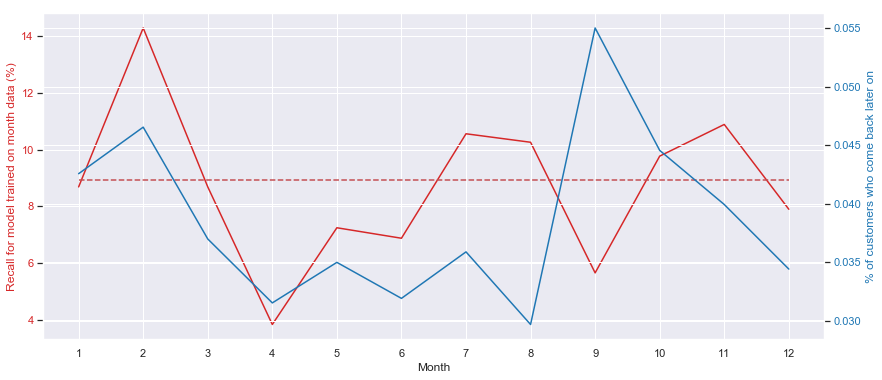

In [258]:
fig, ax1 = plt.subplots()
p = sns.lineplot(range(1, 13), month_recalls, ax=ax1, color='tab:red')
ax1.plot(range(1, 13), [recall_score(true_y, pred_y) * 100] * 12, 'r--')
ax1.set_xlabel("Month")
ax1.set_ylabel("Recall for model trained on month data (%)", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
_ = plt.xticks(range(1, 13))
ax2 = ax1.twinx()
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1, err_style=None, ax=ax2, color='tab:blue')
ax2.set_ylabel("% of customers who come back later on", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Clustering Customers

In [99]:
order_items_joined = orders.join(order_items.set_index('order_id'), on='order_id')[['customer_unique_id', 'product_category', 'price', 'freight_value']]
order_items_joined = pd.DataFrame(order_items_joined.groupby('customer_unique_id').progress_apply(lambda x: [list(y) for y in x.drop('customer_unique_id', axis=1).to_records(index=False)]))
order_items_joined.columns = ['purchases']

In [331]:
customers_joined = customers.set_index('customer_unique_id').join(order_items_joined)

In [332]:
customers_joined

,customer_id,customer_zip_code_prefix,customer_city,customer_state,gdp,size,population,gdp_per_capita,purchases
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP,628064882,248209,44035304,14.262758,"[[cama_mesa_banho, 129.9, 12.0]]"
0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP,628064882,248209,44035304,14.262758,"[[beleza_saude, 18.9, 8.29]]"
0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC,17328527,95346,6727148,2.575910,"[[papelaria, 69.0, 17.22]]"
0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,66812,belem,PA,28706165,1247689,8073924,3.555417,"[[telefonia, 25.99, 17.63]]"
0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP,628064882,248209,44035304,14.262758,"[[telefonia, 180.0, 16.89]]"
0004bd2a26a76fe21f786e4fbd80607f,4a913a170c26e3c8052ed0202849b5a8,5036,sao paulo,SP,628064882,248209,44035304,14.262758,"[[ferramentas_jardim, 154.0, 12.98]]"
00050ab1314c0e55a6ca13cf7181fecf,d2509c13692836fc0449e88cf9eb4858,13084,campinas,SP,628064882,248209,44035304,14.262758,"[[telefonia, 27.99, 7.39]]"
00053a61a98854899e70ed204dd4bafe,a81ebb9b32f102298c0c89635b4b3154,80410,curitiba,PR,78892229,199315,11081692,7.119150,"[[esporte_lazer, 191.0, 18.59], [esporte_lazer..."
0005e1862207bf6ccc02e4228effd9a0,3b37fb626fdf46cd99d37ec62afa88ff,25966,teresopolis,RJ,299849795,43696,16461173,18.215579,"[[fashion_bolsas_e_acessorios, 135.0, 15.12]]"


In [431]:
from sklearn.cluster import DBSCAN
import scipy.sparse
from progressbar import ProgressBar

In [421]:
def get_categories(purchases):
    result = set()
    for purchase in purchases:
        result.add(purchase[0])
    return result

In [633]:
num_customers = customers.shape[0]
num_customers = round(num_customers * 0.5) # if we get memory error from trying to build the full array

In [634]:
categories = {}

for i in tqdm_notebook(range(num_customers)):
    categories[i] = get_categories(customers_joined.iloc[i].purchases)

In [635]:
distances = np.zeros([num_customers, num_customers], np.float16)
bar = ProgressBar(max_value=(num_customers-1) * (num_customers) / 2)
count = 0
for i in range(num_customers-1):
    distances[i][i] = 1
    for j in range(i+1, num_customers):
        # calc distance
        # using jaccard index
        intersect = len(categories[i] & categories[j])
        if (intersect > 0):
            distance = intersect / len(categories[i] | categories[j])
            distances[i][j] = distance
            distances[j][i] = distance
    count += (num_customers - i - 2)
    bar.update(count)
bar.finish()

100% (1236014340.0 of 1236014340.0) |####| Elapsed Time: 0:06:48 Time:  0:06:48


In [636]:
distances = 1 - distances

In [640]:
clustering = DBSCAN(metric='precomputed').fit(distances)

C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


MemoryError: 

In [ ]:
pd.Series(clustering.labels_).value_counts()

# Random. 

Analysing sellers and products

In [55]:
product_reviews = order_items.set_index('order_id').join(reviews.set_index('order_id'))[['product_id', 'seller_id', 'review_creation_date', 'review_score']].reset_index(drop=True)

In [59]:
product_reviews.head()

,product_id,seller_id,review_creation_date,review_score
0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-21,5
1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-13,4
2,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-23,5
3,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15,4
4,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-03-02,5


In [57]:
product_reviews.groupby('product_id').size().sort_values(ascending=False).head()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    491
422879e10f46682990de24d770e7f83d    487
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    391
dtype: int64

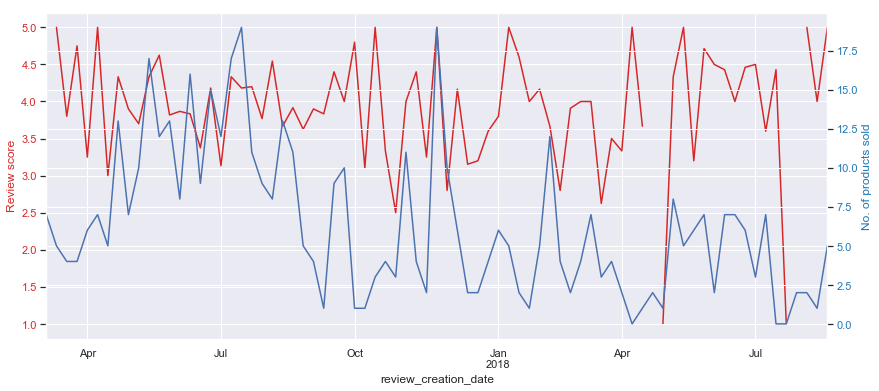

In [97]:
product_id = '99a4788cb24856965c36a24e339b6058'
interval = 'W'
fig, ax1 = plt.subplots()
product_reviews[product_reviews.product_id == product_id].sort_values('review_creation_date').set_index('review_creation_date')['review_score'].resample(interval).mean().plot(color='tab:red')
ax1.set_ylabel("Review score", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
order_items[order_items.product_id == product_id].join(orders.set_index('order_id')[['order_purchase_timestamp']], on='order_id')[['order_purchase_timestamp']].set_index('order_purchase_timestamp').resample(interval).size().plot()
ax2.set_ylabel("No. of products sold", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Others

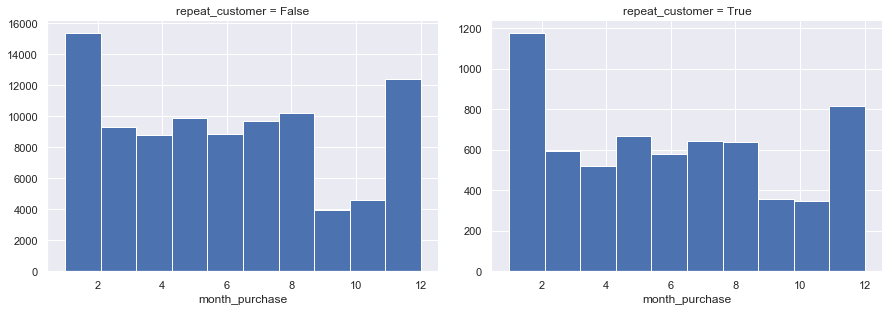

In [170]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "month_purchase")

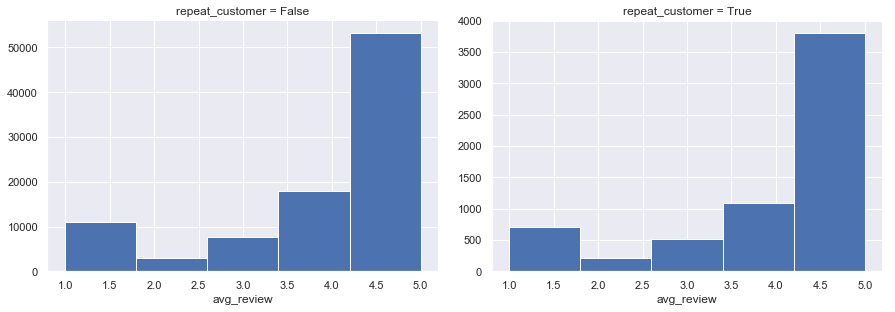

In [180]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "avg_review", bins=5)

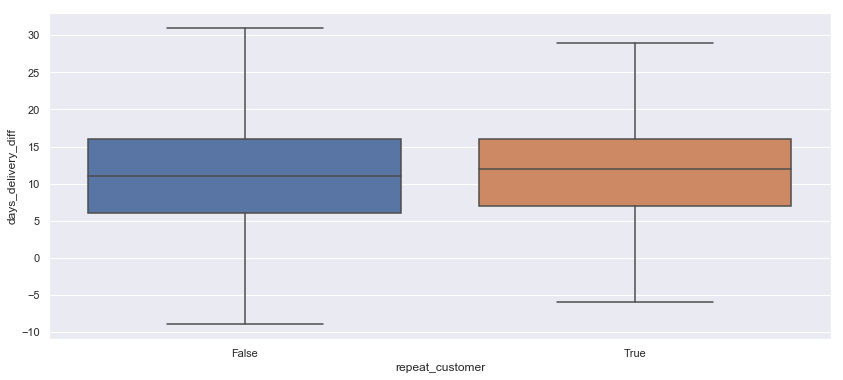

In [197]:
sns.boxplot(orders.repeat_customer, orders.days_delivery_diff, showfliers=False)

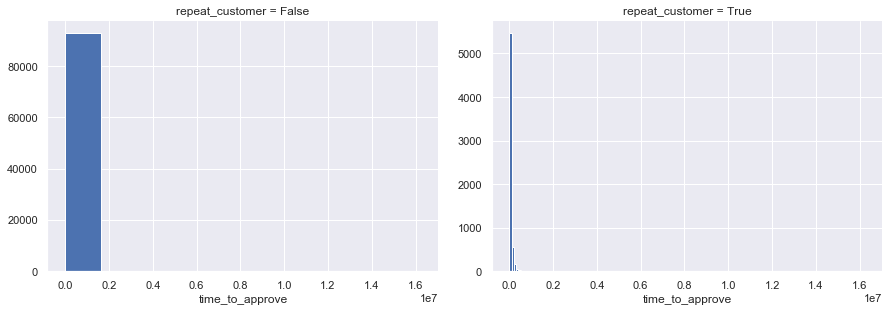

In [201]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "time_to_approve")

In [222]:
orders['time_to_approve_bins'] = pd.qcut(orders.time_to_approve, 10)

In [246]:
results = []
for category in orders['time_to_approve_bins'].cat.categories:
    sub = orders[orders.time_to_approve_bins == category]
    results.append([category, "{0:.3f}".format(sub.repeat_customer.sum() / sub.shape[0] * 100)])
print(tabulate(results, headers=('time_to_approve', '% repeat')))

time_to_approve           % repeat
----------------------  ----------
(-0.001, 605.0]              6.846
(605.0, 721.0]               6.821
(721.0, 832.0]               6.767
(832.0, 978.0]               6.12
(978.0, 1236.0]              6.471
(1236.0, 2214.0]             5.623
(2214.0, 21798.0]            6.487
(21798.0, 76783.0]           6.104
(76783.0, 124775.0]          5.852
(124775.0, 16233050.0]       6.144


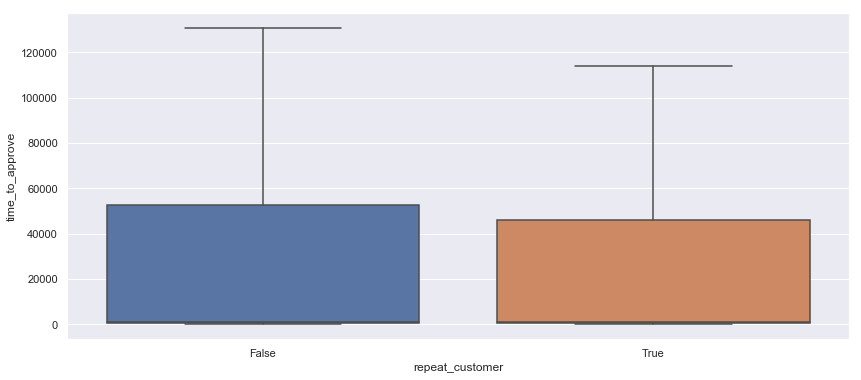

In [200]:
sns.boxplot(orders.repeat_customer, orders.time_to_approve, showfliers=False)